In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import lightgbm as lgb
from sklearn.inspection import permutation_importance
from sklearn.model_selection import RepeatedKFold, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

In [2]:
import optuna
from optuna.samplers import TPESampler
from optuna.study import Study

In [3]:
train = pd.read_csv("../data/train_processed.csv")
# train = train[train["price_type"] == 1]
train.head()

,city,floor,id,lat,lng,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,...,realty_type,price_type,n_floors,age,city_population,city_type,zarplata,floor_type,distance,azimuth
0,красноярск,NaN,COL_62,56.063615,92.958428,0,7,14,26,0,...,110,1,1,41,1067030.0,1Million,NaN,0,4545.771419,50.00
1,саратов,NaN,COL_71,51.534581,46.020549,13,198,345,462,0,...,10,1,1,82,840785.0,Medium,NaN,0,370.873141,25.54
2,красноярск,NaN,COL_140,56.026884,92.818323,3,15,23,33,0,...,10,1,1,48,1067030.0,1Million,NaN,0,5375.758030,257.41
3,иркутск,NaN,COL_202,52.275528,104.251444,0,10,26,40,0,...,10,1,1,45,623479.0,Medium,NaN,0,3172.862066,262.49
4,белгород,NaN,COL_207,50.576545,36.584197,4,48,73,92,0,...,10,1,1,41,378390.0,Medium,NaN,0,2136.479026,177.33


In [4]:
target = "per_square_meter_price"
drop_cols = [target, "id", "price_type", 'date']
cols = [col for col in train.columns if col not in drop_cols]
cat_cols = ["city", "osm_city_nearest_name", "region", "street", 'city_type']

In [5]:
for col in cat_cols:
    train[col] = train[col].astype("category")

In [6]:
train[target] = np.log(train[target])

In [7]:
folds_optuna = RepeatedKFold(n_splits=5, n_repeats=1, random_state=0)

def objective(trial):
    param = {
        "verbosity": -1,
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "n_estimators": trial.suggest_int("n_estimators", 20, 1500),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-8, 10.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 25),
    }
    
    model = lgb.LGBMRegressor(**param)
    score = cross_val_score(model, train[cols], train[target], cv=folds_optuna, scoring="neg_mean_squared_error")
    return score.mean()

In [8]:
sampler = TPESampler(seed=0)
direction = "maximize"
study = optuna.create_study(sampler=sampler, direction=direction)

study.optimize(
    objective,
    show_progress_bar=True,
    n_trials=100,
)

[I 2021-10-13 10:33:44,055] A new study created in memory with name: no-name-5a1f4f2d-d147-45a6-8c35-d65eaaaa03fd
/home/ningeen/anaconda3/envs/interp_ai/lib/python3.8/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2021-10-13 10:33:45,992] Trial 0 finished with value: -2.0941133943328257e+76 and parameters: {'reg_alpha': 0.0008696040132105586, 'reg_lambda': 0.027334069690310565, 'num_leaves': 155, 'n_estimators': 826, 'colsample_bytree': 0.6541928796033428, 'subsample': 0.7875364678399936, 'subsample_freq': 4, 'min_child_samples': 90, 'learning_rate': 4.709392030276881, 'max_depth': 11}. Best is trial 0 with value: -2.0941133943328257e+76.
[I 2021-10-13 10:33:53,399] Trial 1 finished with value: -0.11450563330602784 and parameters: {'reg_alpha': 0.13351354975517513, 'reg_lambda': 0.0005755118598534656, 'num_leaves': 146, 'n_estimators': 1390, 'colsample_bytree': 0.4426216349187322, 'subsample': 0.4522775798209244, 'subsample_freq': 1, 'min_child_samples': 84, 'learning_rate': 0.10078844818976519, 'max_depth': 22}. Best is trial 1 with value: -0.11450563330602784.
[I 2021-10-13 10:33:59,429] Trial 2 finished with value: -0.2156634812547195 and parameters: {'reg_alpha': 6.42044426233932, 'reg_la

[I 2021-10-13 10:36:34,094] Trial 19 finished with value: -0.2778545802417007 and parameters: {'reg_alpha': 0.00017696684068183, 'reg_lambda': 8.952312932944218e-06, 'num_leaves': 86, 'n_estimators': 1288, 'colsample_bytree': 0.806142921398087, 'subsample': 0.9347860742720062, 'subsample_freq': 3, 'min_child_samples': 75, 'learning_rate': 0.00015316470189492647, 'max_depth': 22}. Best is trial 15 with value: -0.1038195828501883.
[I 2021-10-13 10:36:42,066] Trial 20 finished with value: -0.12297395605734733 and parameters: {'reg_alpha': 1.0129651155141237e-07, 'reg_lambda': 2.1503011054295631e-07, 'num_leaves': 196, 'n_estimators': 373, 'colsample_bytree': 0.6853356994747773, 'subsample': 0.7087303988017792, 'subsample_freq': 6, 'min_child_samples': 30, 'learning_rate': 0.004561524431536102, 'max_depth': 13}. Best is trial 15 with value: -0.1038195828501883.
[I 2021-10-13 10:36:59,148] Trial 21 finished with value: -0.10891513241731252 and parameters: {'reg_alpha': 6.455787424667002e-08

[I 2021-10-13 10:41:32,399] Trial 38 finished with value: -0.27714362241681034 and parameters: {'reg_alpha': 1.013023737188769e-08, 'reg_lambda': 0.31504669174262034, 'num_leaves': 67, 'n_estimators': 1431, 'colsample_bytree': 0.6747588284629238, 'subsample': 0.6565637643922451, 'subsample_freq': 5, 'min_child_samples': 100, 'learning_rate': 0.00015067967415144962, 'max_depth': 17}. Best is trial 15 with value: -0.1038195828501883.
[I 2021-10-13 10:41:40,845] Trial 39 finished with value: -0.2493211349542877 and parameters: {'reg_alpha': 1.1909771651006941e-07, 'reg_lambda': 0.0006218489631553562, 'num_leaves': 223, 'n_estimators': 750, 'colsample_bytree': 0.7152935564520062, 'subsample': 0.7562191630342652, 'subsample_freq': 7, 'min_child_samples': 61, 'learning_rate': 0.0004184805928272691, 'max_depth': 8}. Best is trial 15 with value: -0.1038195828501883.
[I 2021-10-13 10:41:46,573] Trial 40 finished with value: -0.11941220409830082 and parameters: {'reg_alpha': 3.280536129546913e-0

[I 2021-10-13 10:47:03,442] Trial 57 finished with value: -0.2457231932983553 and parameters: {'reg_alpha': 3.888200858296706e-06, 'reg_lambda': 5.266916515142276e-06, 'num_leaves': 177, 'n_estimators': 988, 'colsample_bytree': 0.8226425618768968, 'subsample': 0.5237614082245293, 'subsample_freq': 2, 'min_child_samples': 12, 'learning_rate': 0.0003018043264647268, 'max_depth': 10}. Best is trial 55 with value: -0.10052138330871456.
[I 2021-10-13 10:47:30,299] Trial 58 finished with value: -0.10274324132510348 and parameters: {'reg_alpha': 3.770989753085361e-07, 'reg_lambda': 1.7542121282384148e-06, 'num_leaves': 198, 'n_estimators': 1107, 'colsample_bytree': 0.8695367039792115, 'subsample': 0.5674367120604221, 'subsample_freq': 1, 'min_child_samples': 20, 'learning_rate': 0.004038150255563747, 'max_depth': 11}. Best is trial 55 with value: -0.10052138330871456.
[I 2021-10-13 10:48:09,317] Trial 59 finished with value: -0.10217601606670748 and parameters: {'reg_alpha': 1.568983315302412

[I 2021-10-13 10:58:47,551] Trial 76 finished with value: -0.10334232965956688 and parameters: {'reg_alpha': 6.871023742603274e-08, 'reg_lambda': 8.514850467637595e-06, 'num_leaves': 162, 'n_estimators': 1198, 'colsample_bytree': 0.962930374460562, 'subsample': 0.7395255429912027, 'subsample_freq': 1, 'min_child_samples': 7, 'learning_rate': 0.012817695217658956, 'max_depth': 10}. Best is trial 55 with value: -0.10052138330871456.
[I 2021-10-13 10:59:26,180] Trial 77 finished with value: -0.10069552651944277 and parameters: {'reg_alpha': 1.4523499611649069e-06, 'reg_lambda': 7.660224224209827e-07, 'num_leaves': 204, 'n_estimators': 1041, 'colsample_bytree': 0.9280787837742016, 'subsample': 0.6670781999833919, 'subsample_freq': 1, 'min_child_samples': 13, 'learning_rate': 0.00464852690025172, 'max_depth': 12}. Best is trial 55 with value: -0.10052138330871456.
[I 2021-10-13 10:59:53,906] Trial 78 finished with value: -0.10918290099309477 and parameters: {'reg_alpha': 1.2921904545030755e

[I 2021-10-13 11:10:10,321] Trial 95 finished with value: -0.10144385058886729 and parameters: {'reg_alpha': 1.4870428916713902e-07, 'reg_lambda': 2.0201727832055403e-08, 'num_leaves': 162, 'n_estimators': 1317, 'colsample_bytree': 0.8749088384301995, 'subsample': 0.7729216907520232, 'subsample_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.006472022030608096, 'max_depth': 14}. Best is trial 55 with value: -0.10052138330871456.
[I 2021-10-13 11:10:56,057] Trial 96 finished with value: -0.1009805453742458 and parameters: {'reg_alpha': 7.533528892811522e-08, 'reg_lambda': 2.138175563415697e-08, 'num_leaves': 166, 'n_estimators': 1311, 'colsample_bytree': 0.8504029041746918, 'subsample': 0.7827666288044056, 'subsample_freq': 1, 'min_child_samples': 18, 'learning_rate': 0.006273443626274521, 'max_depth': 15}. Best is trial 55 with value: -0.10052138330871456.
[I 2021-10-13 11:11:24,278] Trial 97 finished with value: -0.10382025413598686 and parameters: {'reg_alpha': 1.76666056734988

In [9]:
study.best_params

{'reg_alpha': 6.509148825494632e-08,
 'reg_lambda': 1.823229475907686e-08,
 'num_leaves': 162,
 'n_estimators': 1370,
 'colsample_bytree': 0.8507214842610268,
 'subsample': 0.5068912539055478,
 'subsample_freq': 1,
 'min_child_samples': 18,
 'learning_rate': 0.006533652298850138,
 'max_depth': 15}

In [14]:
study.trials_dataframe().sort_values("value", ascending=False).head(15)

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_min_child_samples,params_n_estimators,params_num_leaves,params_reg_alpha,params_reg_lambda,params_subsample,params_subsample_freq,state
99,99,-0.100332,2021-10-13 11:12:00.267450,2021-10-13 11:12:33.630255,0 days 00:00:33.362805,0.850721,0.006534,15,18,1370,162,6.509149e-08,1.823229e-08,0.506891,1,COMPLETE
98,98,-0.100469,2021-10-13 11:11:24.280942,2021-10-13 11:12:00.265268,0 days 00:00:35.984326,0.850816,0.005614,15,18,1344,162,1.743154e-07,1.855910e-08,0.501732,1,COMPLETE
55,55,-0.100521,2021-10-13 10:45:05.982918,2021-10-13 10:46:02.182517,0 days 00:00:56.199599,0.828521,0.005178,18,13,1232,187,1.437691e-07,4.822932e-06,0.523610,1,COMPLETE
71,71,-0.100637,2021-10-13 10:54:42.411237,2021-10-13 10:55:38.057924,0 days 00:00:55.646687,0.778971,0.003236,13,8,1255,191,4.655206e-06,4.219731e-07,0.537376,1,COMPLETE
86,86,-0.100655,2021-10-13 11:02:45.909990,2021-10-13 11:03:30.502748,0 days 00:00:44.592758,0.783523,0.006685,14,10,1045,218,3.183575e-06,8.220700e-06,0.705362,1,COMPLETE
77,77,-0.100696,2021-10-13 10:58:47.554644,2021-10-13 10:59:26.180285,0 days 00:00:38.625641,0.928079,0.004649,12,13,1041,204,1.452350e-06,7.660224e-07,0.667078,1,COMPLETE
96,96,-0.100981,2021-10-13 11:10:10.323510,2021-10-13 11:10:56.056747,0 days 00:00:45.733237,0.850403,0.006273,15,18,1311,166,7.533529e-08,2.138176e-08,0.782767,1,COMPLETE
56,56,-0.101283,2021-10-13 10:46:02.186574,2021-10-13 10:46:34.365466,0 days 00:00:32.178892,0.830875,0.004642,12,15,1093,184,1.495719e-07,4.241013e-06,0.532804,1,COMPLETE
81,81,-0.101290,2021-10-13 11:00:41.605396,2021-10-13 11:01:13.422507,0 days 00:00:31.817111,0.874956,0.005391,11,14,1126,172,8.433571e-07,1.861833e-06,0.782263,1,COMPLETE
95,95,-0.101444,2021-10-13 11:09:16.665527,2021-10-13 11:10:10.320536,0 days 00:00:53.655009,0.874909,0.006472,14,18,1317,162,1.487043e-07,2.020173e-08,0.772922,1,COMPLETE


In [19]:
study.trials[45].params

{'reg_alpha': 3.842394964647047e-06,
 'reg_lambda': 1.3457165400059045e-07,
 'num_leaves': 185,
 'n_estimators': 329,
 'colsample_bytree': 0.7609454453893679,
 'subsample': 0.4007257897002692,
 'subsample_freq': 6,
 'min_child_samples': 8,
 'learning_rate': 0.01375836425783044,
 'max_depth': 18}

In [10]:
N_SPLITS = 5
N_REPEATS = 3

folds = RepeatedKFold(n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=0)

In [20]:
params = {'reg_alpha': 3.842394964647047e-06,
 'reg_lambda': 1.3457165400059045e-07,
 'num_leaves': 185,
 'n_estimators': 329,
 'colsample_bytree': 0.7609454453893679,
 'subsample': 0.4007257897002692,
 'subsample_freq': 6,
 'min_child_samples': 8,
 'learning_rate': 0.01375836425783044,
 'max_depth': 18}

model = lgb.LGBMRegressor(**params)

In [21]:
# Score: -0.1011

score = cross_val_score(model, train[cols], train[target], cv=folds, scoring="neg_mean_squared_error")
print(f"Score: {score.mean():.4f}")

Score: -0.1027


In [22]:
n_total = N_SPLITS * N_REPEATS
importances = np.zeros((n_total, len(cols)))

for i, (train_idx, val_idx) in tqdm(enumerate(folds.split(train)), total=n_total):
    X_train, X_val = train[cols].iloc[train_idx], train[cols].iloc[val_idx]
    y_train, y_val = train[target].iloc[train_idx], train[target].iloc[val_idx]
    
    model.fit(X_train, y_train)

    result = permutation_importance(
        model, 
        X_val, 
        y_val, 
        scoring="neg_mean_squared_error",
        n_repeats=1,
        random_state=42
    )
    importances[i] = result.importances_mean

  0%|          | 0/15 [00:00<?, ?it/s]

In [23]:
imp = pd.DataFrame(importances, columns=cols).T.mean(axis=1).sort_values(ascending=False).reset_index()
imp.columns = ["feature", "importance"]
imp.head()

,feature,importance
0,city_population,0.038680
1,total_square,0.035187
2,city,0.015979
3,osm_catering_points_in_0.005,0.007031
4,region,0.005021


In [25]:
(imp["importance"] > 1e-3).sum()

21

In [59]:
imp_cols = imp.loc[imp["importance"] > 1e-3, "feature"].tolist()

# imp_cols = [
#     'total_square',
#     'city',
#     'region',
#     'floor',
#     'realty_type',
#     'osm_catering_points_in_0.01',
#     'osm_city_nearest_name',
#     'osm_city_nearest_population',
#     'reform_mean_floor_count_500',
#     'osm_crossing_closest_dist',
#     'osm_amenity_points_in_0.001',
#     'osm_transport_stop_closest_dist',
#     'reform_mean_floor_count_1000',
#     'osm_subway_closest_dist',
#     'osm_city_closest_dist',
#     'reform_mean_year_building_500',
#     'osm_hotels_points_in_0.005',
#     'reform_house_population_500',
#     'osm_transport_stop_points_in_0.0075',
#     'osm_shops_points_in_0.005',
# ]

imp_cols = [
    'city_population',
    'total_square',
    'osm_catering_points_in_0.005',
    'region',
    'floor',
    'realty_type',
    'osm_crossing_closest_dist',
    'osm_city_nearest_name',
    'osm_subway_closest_dist',
    'reform_mean_floor_count_1000',
    'osm_transport_stop_closest_dist',
    'osm_amenity_points_in_0.001',
    'osm_city_nearest_population',
    'lng',
    'osm_city_closest_dist',
    'osm_crossing_points_in_0.005',
    'floor_type',
    'lat',
    'reform_mean_year_building_500',
    'osm_culture_points_in_0.005',
    'reform_house_population_500',
]
len(imp_cols)

21

In [60]:
score = cross_val_score(model, train[imp_cols], train[target], cv=folds, scoring="neg_mean_squared_error")
print(f"Score: {score.mean():.4f}")

Score: -0.1022


<AxesSubplot:>

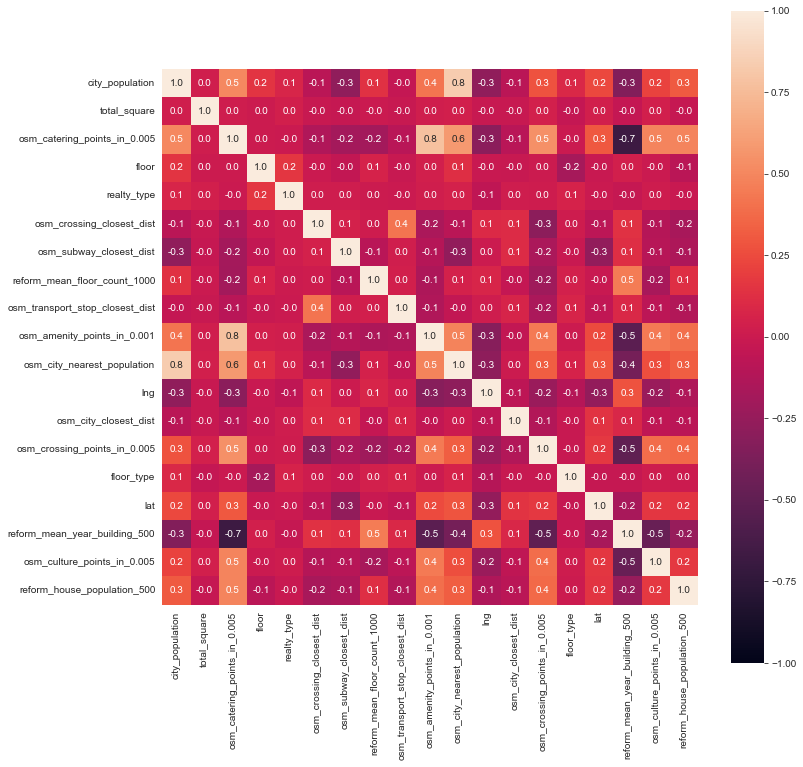

In [61]:
plt.figure(figsize=(12, 12))
sns.heatmap(train[imp_cols].corr(), vmin=-1, vmax=1, square=True, annot=True, fmt=".1f")

In [68]:
train = pd.read_csv("../data/train_processed_big.csv")
train[imp_cols + [target, "price_type"]].to_csv("../data/train_simple.csv", index=False)

In [67]:
train.shape

(279792, 85)